Initialize Google Earth Engine.

In [10]:
%matplotlib inline
from functools import reduce
import ee
import datetime
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

from sklearn import mixture


import seaborn as sns
sns.set()

import datashader as ds
import datashader.transfer_functions as tf

import holoviews as hv
import holoviews.plotting.mpl
hv.notebook_extension()

from itertools import chain

from matplotlib.backends.backend_pdf import PdfPages

In [11]:
from datashader import reductions
import bokeh.palettes as p
import colorcet as c



In [12]:
ee.Initialize()

INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:oauth2client.client:Refreshing access_token


In [13]:
# rescales to given ranges
def rescale(img, exp, thresholds):
    return img.expression(exp, {'img': img}).subtract(thresholds[0]).divide(thresholds[1] - thresholds[0])

def add_cloud_score(img):
    # Compute several indicators of cloudyness and take the minimum of them.
    score = ee.Image(1.0)

    # Clouds are reasonably bright in the blue band.
    score = score.min(rescale(img, 'img.blue', [0.1, 0.3]))

    # Clouds are reasonably bright in all visible bands.
    score = score.min(rescale(img, 'img.red + img.green + img.blue', [0.3, 0.8]))

    # Clouds are reasonably bright in all infrared bands.
    score = score.min(rescale(img, 'img.nir + img.swir1 + img.swir2', [0.3, 0.8]))

    # Clouds are reasonably cool in temperature.
    score = score.min(rescale(img, 'img.temp', [293, 268]))

    # However, clouds are not snow.
    # let ndsi = img.normalizedDifference(['red', 'swir'])
    # score = score.min(rescale(ndsi, 'img', [0.2, 0.0]))

    ndsi = img.normalizedDifference(['green', 'swir1'])
    
    score = score.min(rescale(ndsi, 'img', [0.8, 0.6]))
    
    return img.addBands(score.rename(['cloud']))
    
def add_snow_score(img):
    # Compute several indicators of snowyness and take the minimum of them.
    score = ee.Image(1.0)

    # Snow is reasonably bright in the blue band.
    score = score.min(rescale(img, 'img.blue', [0.1, 0.3]))

    # Snow is reasonably bright in all visible bands.
    score = score.min(rescale(img, 'img.red + img.green + img.blue', [0.2, 0.8]))

    # Excluded this for snow reasonably bright in all infrared bands.
    score = score.min(rescale(img, 'img.nir + img.swir1 + img.swir2', [0.2, 0.4]))

    # Snow is reasonably cool in temperature.
    # start from 0C
    score = score.min(rescale(img, 'img.temp', [300, 273.15]))

    # Snow is high in ndsi.
    ndsi = img.normalizedDifference(['red', 'swir1']);
    ndsi = rescale(ndsi, 'img', [0.3, 0.5]);
    score = score.min(ndsi)

    score = rescale(score.clamp(0, 0.5), 'img', [0, 0.5]).toFloat()
    
    return img.addBands(score.rename(['snow']))


In [14]:
wavelengths = [.45, .52, .63, .77, 1.55, 2.09]

bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp']
info = [
    {'name': 'LANDSAT/LT4_L1T', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6'], 'multiplier': 1/255}, 
    {'name': 'LANDSAT/LT5_L1T', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6'], 'multiplier': 1/255}, 
    {'name': 'LANDSAT/LE7_L1T', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6_VCID_1'], 'multiplier': 1/255}, 
    {'name': 'LANDSAT/LC8_L1T', 'bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'], 'multiplier': 1/65535}
]

bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
info = [
    {'name': 'LANDSAT/LT4_SR', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'], 'multiplier': 0.0001}, 
    {'name': 'LANDSAT/LT5_SR', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'], 'multiplier': 0.0001}, 
    {'name': 'LANDSAT/LE7_SR', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'], 'multiplier': 0.0001}, 
    {'name': 'LANDSAT/LC8_SR', 'bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'], 'multiplier': 0.0001}
]

bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp']
info = [
    {'name': 'LANDSAT/LT4_L1T_TOA', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6']}, 
    {'name': 'LANDSAT/LT5_L1T_TOA', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6']}, 
    {'name': 'LANDSAT/LE7_L1T_TOA', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6_VCID_1']}, 
    {'name': 'LANDSAT/LC8_L1T_TOA', 'bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']}
]

def fix_mask(image):
    mask = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(mask)

def get_collection(info):
    c = ee.ImageCollection(info['name']).select(info['bands'], bands)
    
    if 'multiplier' in info:
        c = c.map(lambda i: i
                  .multiply(float(info['multiplier'])).copyProperties(i, ['system:time_start', 'system:id']))
    
    return c
    
def get_data(start, stop, region):
    images = reduce((lambda c1, c2: ee.ImageCollection(c1).merge(c2)), map(get_collection, info))
    images = ee.ImageCollection(images)
    images = images.filterBounds(region)
    images = images.filterDate(start, stop)
    images = images.map(fix_mask)
    images = images.map(add_cloud_score)
    images = images.map(add_snow_score)
    
    # images = images.filter(ee.Filter.dayOfYear(150, 270))

    try:
        response = images.getRegion(region, 30).getInfo()

        header = response[0] # extract the header column names
        data = np.transpose(np.array(response[1:])) # create a Numpy array of the data
    
        return (header, data)
    except Exception as e:
        print(e)
        return ([], [])

In [38]:
point = {'type':'Point', 'coordinates':[-120.14382362365723,39.380816241660135]} # Prosser Creek Reservoir (center)

# point = {'type':'Point', 'coordinates':[-120.14375925064087,39.37772765378145]} # Prosser Creek Reservoir (water edge)


# point = {'type':'Point', 'coordinates': [-120.05138397216797,39.12180381489474]} # Lake Tahoe

# point = {'type':'Point', 'coordinates': [-120.12871742248535,39.38609027098774]} # ground, vegetated

x = point['coordinates'][0]
y = point['coordinates'][1]

poi = point

In [39]:
# get all pixels

step = 0.000813927198733891
rx = 15 # pixels
ry = 15 # pixels

#rx = 3 # pixels
#ry = 3 # pixels

polygon = ee.Geometry.Polygon([[x-step*rx, y-step*ry], [x+step*rx, y-step*ry], 
                               [x+step*rx, y+step*ry], [x-step*rx, y+step*ry], 
                               [x-step*rx, y-step*ry]])

# define point of interest
poi = polygon


In [40]:
# https://code.earthengine.google.com/079893aea553f47ca45aa79e254d1c9b

# line along water and land
poi = ee.Geometry.LineString([[-120.14679551124573, 39.38142437834914], [-120.14924168586731, 39.374648881600756]])

In [15]:
# polygon water+soil (Prosser Creek Reservoir)
poi = ee.Geometry.Polygon([[[-120.15180587768555, 39.37554457862171], [-120.14723539352417, 39.3743669005306],
                            [-120.14463901519775, 39.3809516906138], [-120.14933824539185, 39.381830721387516]]])


In [42]:
# polygon water-only (Prosser Creek Reservoir)
poi = ee.Geometry.Polygon([[[-120.15043258666992, 39.37912725179042],
          [-120.14573335647583, 39.37828135942908],
          [-120.14570118043366, 39.37842233071307],
          [-120.14471946613457, 39.380930950114795],
          [-120.14463901519775, 39.3809516906138],
          [-120.14929533004761, 39.38173120902543]]])

In [16]:
print(poi)

ee.Geometry({
  "evenOdd": true,
  "coordinates": [
    [
      [
        -120.15180587768555,
        39.37554457862171
      ],
      [
        -120.14723539352417,
        39.3743669005306
      ],
      [
        -120.14463901519775,
        39.3809516906138
      ],
      [
        -120.14933824539185,
        39.381830721387516
      ]
    ]
  ],
  "type": "Polygon"
})


In [17]:
# number of images
images = reduce((lambda c1, c2: ee.ImageCollection(c1).merge(c2)), map(get_collection, info))
images = ee.ImageCollection(images)
images = images.filterBounds(poi)
print(images.size().getInfo())

930


In [18]:
def get_date_intervals(t0, t1, step_days):
    t = t0
    while t < t1:
        yield [t, t + datetime.timedelta(days=step_days) - datetime.timedelta(seconds=1)]
        t = t + datetime.timedelta(days=step_days)


In [19]:
data = []
header = None

    
t0 = datetime.datetime(1984, 1, 1)
# t0 = datetime.datetime(2013, 1, 1)
t1 = datetime.datetime(2018, 1, 1)

step_years = 5
step_days = 365 * step_years

# step_days = 120

for i in get_date_intervals(t0, t1, step_days):
    (h, d) = get_data(i[0], i[1], poi)
    
    if len(d) == 0:
        print('{0} - {1}, no data'.format(i[0], i[1]))
        continue

    if not len(data):
        data = d
        header = h
    else: 
        data = np.c_[data, d]

    print('{0} - {1}, {2}'.format(i[0], i[1], len(d[0])))

# extract the time information
time = [datetime.datetime.fromtimestamp(int(i) / 1000) for i in (data[header.index('time')])] 


1984-01-01 00:00:00 - 1988-12-29 23:59:59, 29370
1988-12-30 00:00:00 - 1993-12-28 23:59:59, 31150
1993-12-29 00:00:00 - 1998-12-27 23:59:59, 42275
1998-12-28 00:00:00 - 2003-12-26 23:59:59, 81880
2003-12-27 00:00:00 - 2008-12-24 23:59:59, 86330
2008-12-25 00:00:00 - 2013-12-23 23:59:59, 77430
2013-12-24 00:00:00 - 2018-12-22 23:59:59, 64970


In [20]:
print(np.shape(data))


(13, 413405)


In [13]:
header


['id',
 'longitude',
 'latitude',
 'time',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'temp',
 'cloud',
 'snow']

In [14]:
import pandas as pd

In [9]:
df = pd.DataFrame(np.transpose(data[1:].astype(float)), columns=header[1:])

df = df[~np.isnan(df['green'])]
df = df[~np.isnan(df['nir'])]
df = df[~np.isnan(df['swir1'])]
df = df[~np.isnan(df['temp'])]


NameError: name 'data' is not defined

In [16]:
df

,longitude,latitude,time,blue,green,red,nir,swir1,swir2,temp,cloud,snow
0,-120.148097,39.374641,4.517644e+11,0.127838,0.105903,0.103150,0.123635,0.100208,0.069648,280.652405,-0.013018,0.000000
1,-120.148097,39.374641,4.545292e+11,0.099932,0.094985,0.090277,0.214763,0.208447,0.153301,306.412109,-0.536484,0.000000
2,-120.148097,39.374641,4.572941e+11,0.097844,0.095393,0.095718,0.222004,0.203241,0.136435,306.412109,-0.536484,0.000000
3,-120.148097,39.374641,4.642062e+11,0.103877,0.103175,0.116269,0.187961,0.242933,0.168378,306.412109,-0.536484,0.000000
4,-120.148097,39.374641,4.655886e+11,0.102745,0.094130,0.106409,0.162953,0.213411,0.152294,291.983551,0.006567,0.000000
5,-120.148097,39.374641,4.669710e+11,0.272104,0.251242,0.267816,0.314226,0.083272,0.060820,272.924042,0.316635,1.000000
6,-120.148097,39.374641,4.752654e+11,0.615936,0.658973,0.652723,0.640346,0.027383,0.021074,263.377045,-0.601041,1.000000
7,-120.148097,39.374641,4.849422e+11,0.098242,0.095780,0.096107,0.175328,0.236741,0.180979,302.746826,-0.389873,0.000000
8,-120.148097,39.374641,4.877070e+11,0.096913,0.094485,0.094808,0.204247,0.207351,0.149602,309.981262,-0.679250,0.000000
9,-120.148097,39.374641,4.904718e+11,0.104554,0.099728,0.107549,0.196724,0.225153,0.156467,308.009796,-0.600392,0.000000


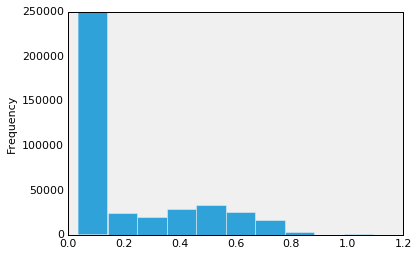

In [18]:
df.green.plot(kind='hist')

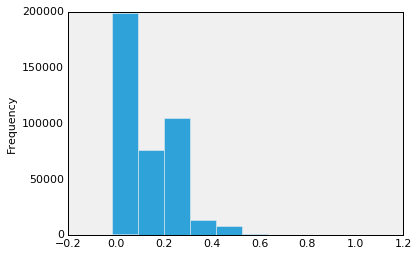

In [19]:
df.swir1.plot(kind='hist')

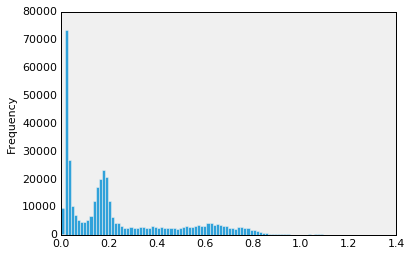

In [21]:
df.nir.plot(kind='hist', bins=100)

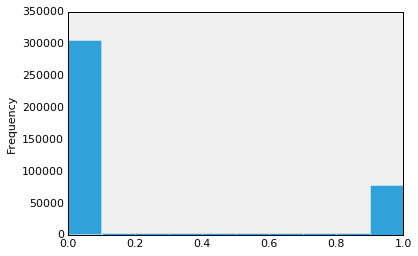

In [17]:
df.snow.plot(kind='hist')

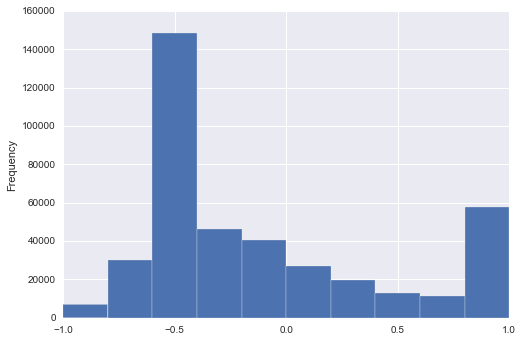

In [112]:
df.cloud.plot(kind='hist')

In [28]:
header

['id',
 'longitude',
 'latitude',
 'time',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'temp',
 'cloud',
 'snow']

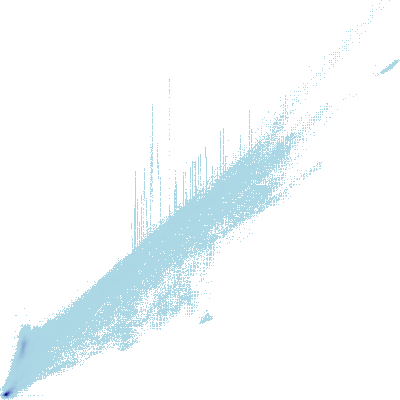

In [29]:
canvas = ds.Canvas(plot_width=400, plot_height=400)
agg = canvas.points(df, 'green', 'nir')

tf.shade(agg, cmap=['lightblue', 'darkblue'], how='linear')

In [30]:
# P(... | clouds = 0)
# P(... | snow = 0)
df = df[df.cloud < 0.2]
df = df[df.snow < 0.3]

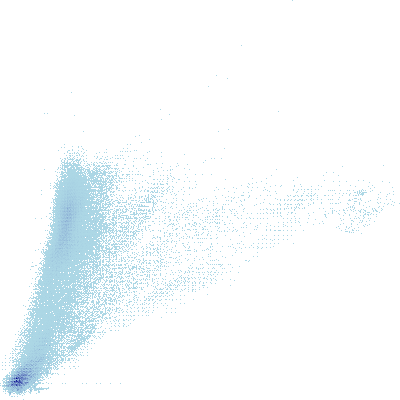

In [31]:
canvas = ds.Canvas(plot_width=400, plot_height=400)
agg = canvas.points(df, 'green', 'nir')

tf.shade(agg, cmap=['lightblue', 'darkblue'], how='linear')

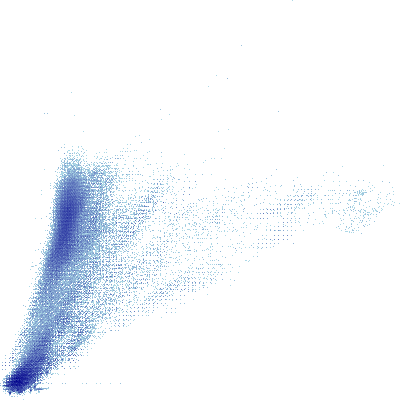

In [32]:
canvas = ds.Canvas(plot_width=400, plot_height=400)
agg = canvas.points(df, 'green', 'nir')

tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')

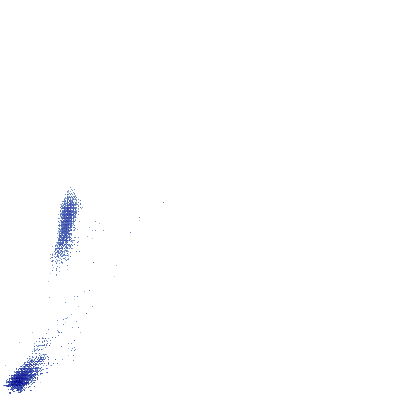

In [33]:
canvas = ds.Canvas(plot_width=400, plot_height=400)
agg = canvas.points(df, 'green', 'nir')

tf.shade(agg.where(agg>=np.percentile(agg,99)), cmap=['lightblue', 'darkblue'], how='log')

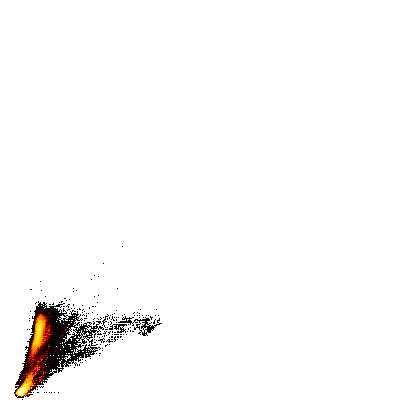

In [34]:
canvas = ds.Canvas(plot_width=400, plot_height=400, x_range=(0,1), y_range=(0,1))

agg  = canvas.points(df, 'green', 'nir')

img1 = tf.shade(canvas.points(df,'green','nir',agg=reductions.count()), cmap=c.fire, alpha=250, how='linear')
s1 = img1 #tf.spread(img1, px=1, shape='circle')

img2 = tf.shade(agg.where(agg>=np.percentile(agg,99.2)), cmap=p.RdGy11, alpha=99)
img2 = tf.shade(agg.where(agg>=np.percentile(agg,99.2)), cmap=c.fire, alpha=255, how='eq_hist')
s2 = img2 # tf.spread(img2, px=2, shape='square', how='over')

tf.stack(s1, s2)

In [35]:
%opts Points [color_index=2] (cmap="bwr" edgecolors='k' s=0.1 alpha=1.0)
%opts Scatter3D [color_index=3 fig_size=25] (cmap='bwr' edgecolor='k' s=0.1 alpha=1.0)
%opts Image (cmap="gray_r") {+axiswise}

holoviews.plotting.mpl.MPLPlot.fig_alpha = 0
holoviews.plotting.mpl.ElementPlot.bgcolor = 'white'


In [36]:
from skimage.exposure import equalize_hist

eq_hist = lambda d,m: equalize_hist(1000*d,nbins=100000,mask=m)

:Layout
   .Image.Green_vs_nir.I  :Image   [x,y]   (z)
   .Image.Green_vs_nir.II :Image   [x,y]   (z)
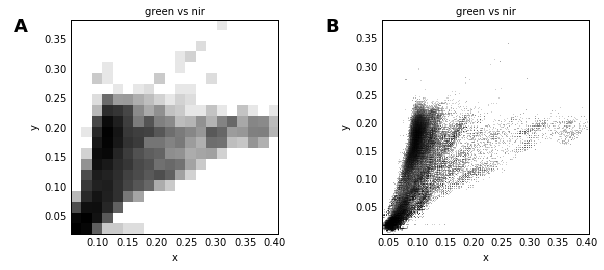

In [37]:
def heatmap(coords,bins=10,offset=0.0,transform=lambda d,m:d, label=None):
    """
    Given a set of coordinates, bins them into a 2d histogram grid
    of the specified size, and optionally transforms the counts
    and/or compresses them into a visible range starting at a 
    specified offset between 0 and 1.0.
    """
    hist,xs,ys  = np.histogram2d(coords[0], coords[1], bins=bins)
    counts      = hist[:,::-1].T
    transformed = transform(counts,counts!=0)
    span        = transformed.max()-transformed.min()
    compressed  = np.where(counts!=0,offset+(1.0-offset)*transformed/span,0)
    args        = dict(label=label) if label else {}
    
    return hv.Image(compressed,bounds=(xs[-1],ys[-1],xs[1],ys[1]),**args)

values = [df['green'], df['nir']]
label = 'green vs nir'
hv.Layout([heatmap(values, bins, transform=eq_hist, label=label) for bins in [20,100,200]])

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
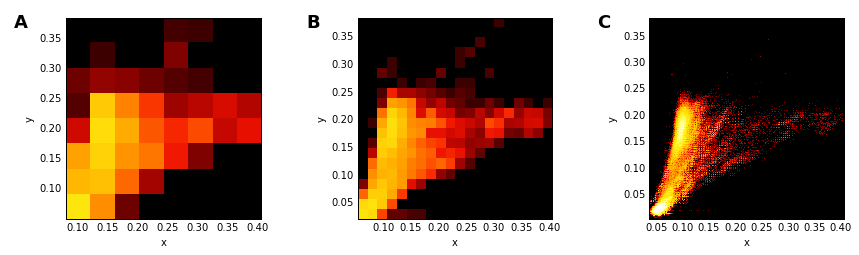

In [38]:
hv.Layout([heatmap(values,bins,transform=eq_hist)(style=dict(cmap="cet_fire")) for bins in [8,20,200]])

In [40]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()

x = df['blue']
#x = df['green']
#x = df['swir1']
#y = df['nir']
#y = df['swir1']
y = df['nir']

p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(x.min(),x.max()), y_range=(y.min(),y.max()), active_scroll="wheel_zoom", 
              webgl=True)

def image_callback(x_range, y_range, w, h):
    canvas = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = canvas.points(df, x.name, y.name)
    
    agg = agg.where(agg>=np.percentile(agg, 99.5))
    img = tf.shade(agg, cmap=c.fire, how='log')
    #img = tf.set_background(img, 'black')
    
    return tf.dynspread(img)

InteractiveImage(p, image_callback)


ImportError: cannot import name '_ModelInDocument'

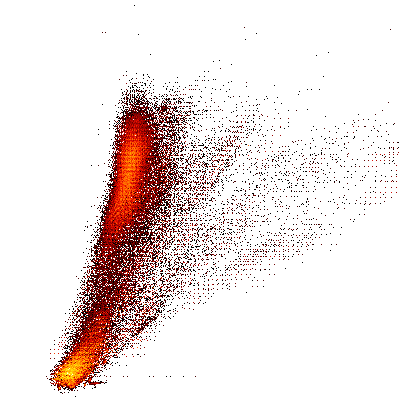

In [41]:
# fit gaussian

canvas = ds.Canvas(plot_width=400, plot_height=400, x_range=[0,0.3], y_range=[0, 0.3])
agg = canvas.points(df, 'green', 'nir')

#agg = agg.where(agg>=np.percentile(agg, 99))

img = tf.shade(agg, cmap=c.fire, how='log')
#img = tf.set_background(img, 'black')
    
d=tf.dynspread(img)

d

In [42]:
a = np.nan_to_num(agg)

In [43]:
agg

<xarray.DataArray (y_axis: 400, x_axis: 400)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y_axis   (y_axis) float64 0.0 0.0007519 0.001504 0.002256 0.003008 ...
  * x_axis   (x_axis) float64 0.0 0.0007519 0.001504 0.002256 0.003008 ...

In [44]:
import scipy.stats as stats

In [24]:
m1, m2 = df['green'], df['swir1']
xmin, xmax = min(m1)-0.1, max(m1)
ymin, ymax = min(m2)-0.1, max(m2)

# Perform a kernel density estimate (KDE) on the data
x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([x.ravel(), y.ravel()])
values = np.vstack([m1, m2])

kernel = stats.gaussian_kde(values)

data2 = np.reshape(kernel(positions).T, x.shape)


Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'linalg', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-0.1, 1)

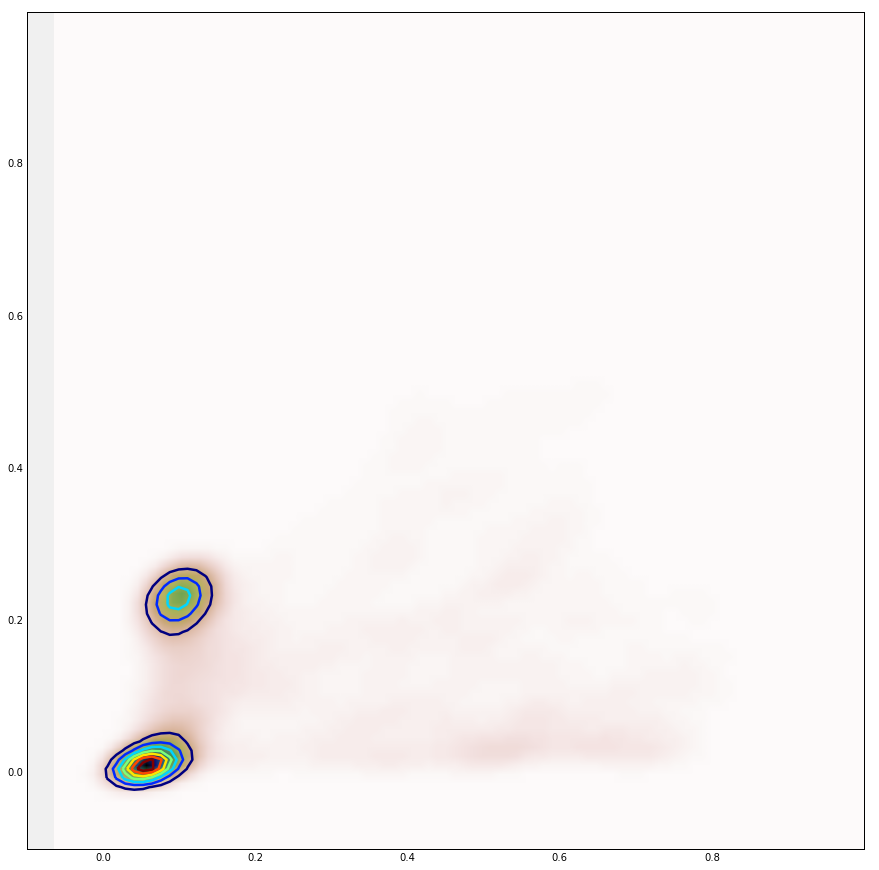

In [25]:
%pylab inline

f, ax = plt.subplots(figsize=(15, 15))

# Set limits
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# KDE density plot
plt.imshow(np.rot90(data2), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])

# Draw contour lines
cset = plt.contour(x,y,data2)

print(cset)
#plt.clabel(cset, inline=1, fontsize=10)
#plt.colorbar()

plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)

# plt.scatter(df['green'], df['swir1'], c='r', s=0.1)




C:\Program Files\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


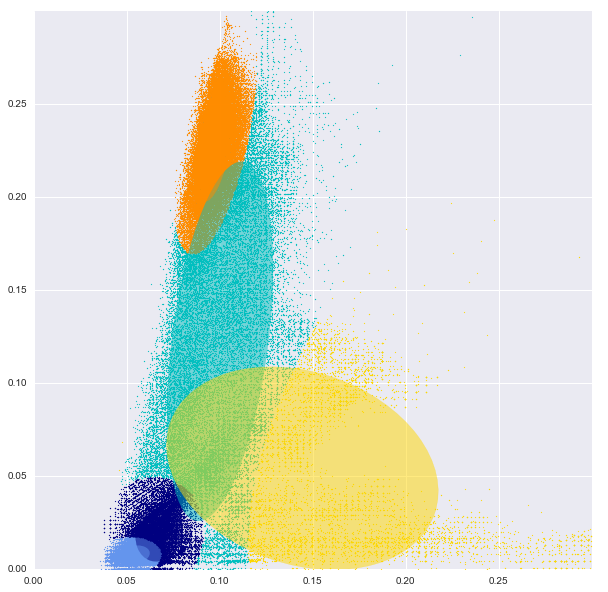

In [146]:
# select samples
samples = df[['green', 'swir1']]
samples = samples[samples['green'] < 0.3]
samples = samples[samples['swir1'] < 0.3]

X = np.array(samples)


# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

f, ax = plt.subplots(figsize=(10, 10))

Y_ = dpgmm.predict(X)
means = dpgmm.means_
covariances = dpgmm.covariances_

for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])

    # as the DP will not use every component it has access to unless it needs it, we shouldn't plot the redundant components.
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

plt.xlim(0, 0.3)
plt.ylim(0, 0.3)

plt.show()


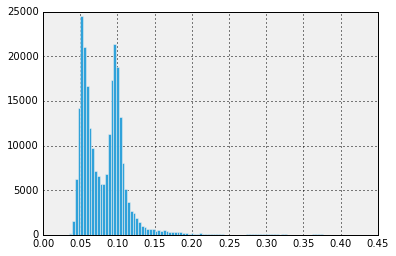

In [61]:
df['green'].hist(bins=100)

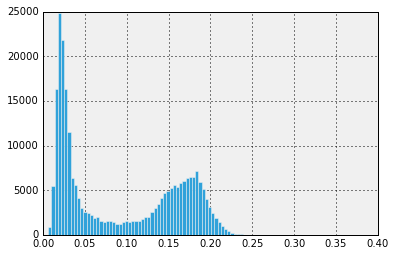

In [55]:
df['nir'].hist(bins=100)

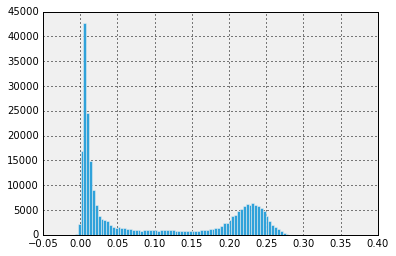

In [57]:
df['swir1'].hist(bins=100)

In [5]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()

x = df['green']
y = df['swir1']
#y = df['swir1']
#y = df['temp']

p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(x.min(),x.max()), y_range=(y.min(),y.max()), active_scroll="wheel_zoom")

def image_callback(x_range, y_range, w, h):
    canvas = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = canvas.points(df, x.name, y.name)
    img = tf.shade(agg, cmap=c.fire, how='log')
    #img = tf.set_background(img, 'black')
    
    return tf.dynspread(img)

InteractiveImage(p, image_callback)


ImportError: cannot import name '_ModelInDocument'

In [74]:
header[8], header[7], header[5]

('swir1', 'nir', 'green')

In [75]:

import matplotlib
N = matplotlib.colors.Normalize(vmin=0.05,vmax=0.4,clip=True)
# N = matplotlib.colors.Normalize(vmin=0.0,vmax=1.0,clip=True)

# SNG
r = N(data[8].astype(np.float))
g = N(data[7].astype(np.float))
b = N(data[5].astype(np.float))

# RGB
#r = N(data[6].astype(np.float))
#g = N(data[5].astype(np.float))
#b = N(data[4].astype(np.float))

colors = np.c_[r, g, b].filled()
mask = np.isnan(colors).any(axis=1)



In [161]:
import matplotlib
N = matplotlib.colors.Normalize(vmin=0.0,vmax=0.6,clip=True)

# SNG
r = N(df['swir1'].astype(np.float))
g = N(df['nir'].astype(np.float))
b = N(df['green'].astype(np.float))
colors = np.c_[r, g, b].filled()



In [8]:
import pandas as pd
green = pd.Series(df['green'], name=r'$\rho_{green}$')
nir = pd.Series(df['green'], name=r'$\rho_{nir}$')
swir1 = pd.Series(df['swir1'], name=r'$\rho_{swir1}$')

NameError: name 'df' is not defined

In [7]:
sns.plt(x=green, y=swir1, color=colors)

NameError: name 'green' is not defined

In [ ]:
g = sns.JointGrid(x=green, y=swir1, xlim=[0, 1], ylim=[0, 1])

# g.plot_joint(plt.scatter, color=colors, s=0.5, edgecolor="black")

# g.plot_joint(sns.kdeplot, shade=True, n_levels=50)

g.plot_marginals(sns.distplot)  

plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)

TypeError: slice indices must be integers or None or have an __index__ method

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Fi

In [154]:
sns.set(style="white")

# g = sns.jointplot(green, swir1, kind="kde", size=7, space=0)

In [153]:
sns.set_style('darkgrid')

columns=['green', 'nir', 'swir1', 'temp']
# columns=['green', 'nir', 'swir1']


In [187]:
df[columns[0]].values

array([ 0.10590257,  0.09498452,  0.09539266, ...,  0.0524646 ,
        0.05296161,  0.0822026 ])

In [158]:
columns

['green', 'nir', 'swir1', 'temp']

In [188]:
indices=np.triu_indices(len(columns), 1)
indices

(array([0, 0, 0, 1, 1, 2], dtype=int64),
 array([1, 2, 3, 2, 3, 3], dtype=int64))

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


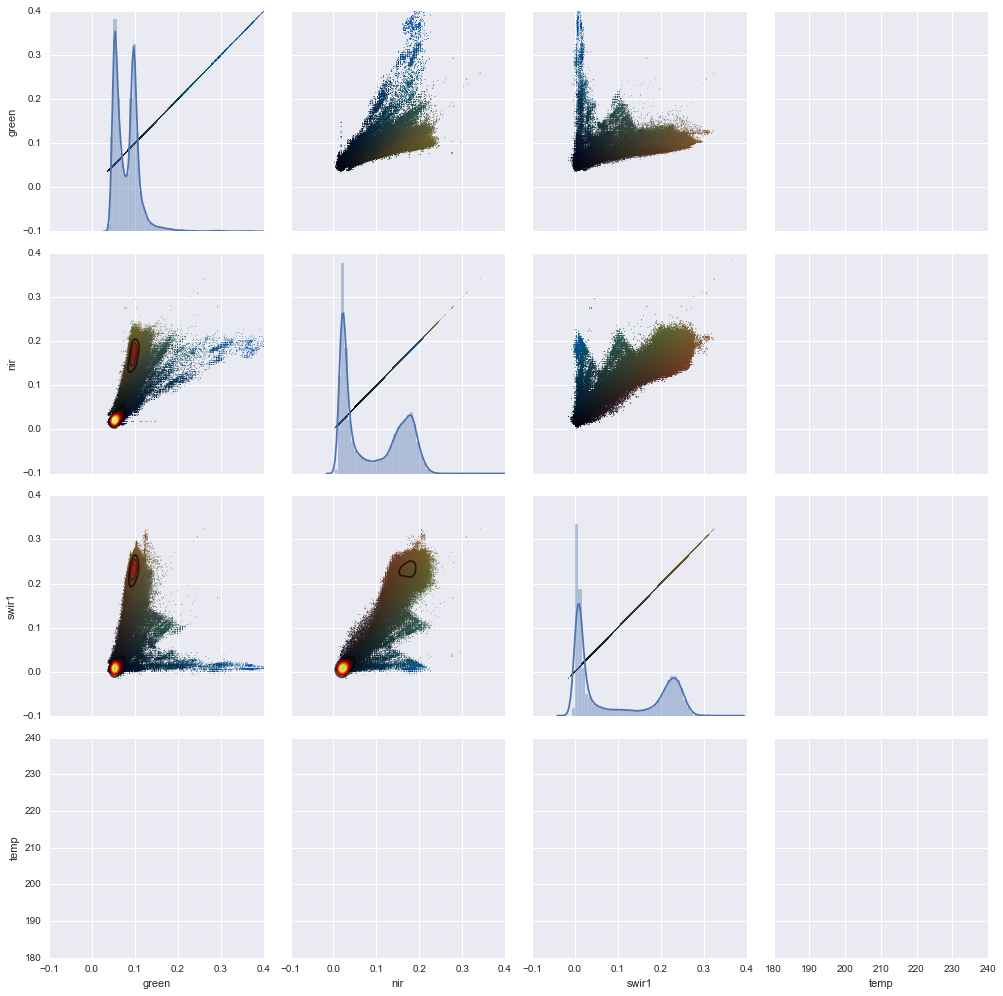

In [216]:
fig = plt.figure(figsize=(12,12))

p = sns.PairGrid(df, vars=columns, size=3.5, dropna=True, diag_sharey=False)

p.map_diag(sns.distplot)
# p.map_lower(plt.scatter, s=0.5, linewidth=0)
p.map_lower(sns.kdeplot, shape=True, linewidth=0, cmap=cm.hot, alpha=0.7)

# plot styled scatters for upper part
indices=np.triu_indices(len(columns), 1)
for index in list(zip(indices[0], indices[1])):
    r=index[0]
    c=index[1]
    p.axes[r, c].scatter(df[columns[c]], df[columns[r]], c=colors, s=0.5, linewidth=0)

# plot styled scatters for lower part
indices=np.tril_indices(len(columns), 1)
for index in list(zip(indices[0], indices[1])):
    r=index[0]
    c=index[1]
    p.axes[r, c].scatter(df[columns[c]], df[columns[r]], c=colors, s=0.5, linewidth=0)

# max_value = 1.1
max_value = 0.4
for ax in chain.from_iterable(zip(*p.axes[0:-1,0:-1])):
    ax.set_xlim(-0.1, max_value)
    ax.set_ylim(-0.1, max_value)

# temp
#temp_min = 180
temp_min = 240
temp_max = 320
for ax in chain.from_iterable(zip(*p.axes[-1:,-1:])):
    ax.set_xlim(180, temp_max)
    ax.set_ylim(180, temp_max)


In [70]:
pdf = PdfPages(r'..\figures\spectral_info_kde_swir1_nir_green.pdf')
pdf.savefig(figure=ax.figure, bbox_inches='tight', dpi=300)
pdf.close()

In [ ]:
fig = plt.figure(1)

p=sns.pairplot(df[columns], size=3, 
             diag_kind='kde', diag_kws=dict(shade=True, linewidth=1),
             plot_kws=dict(s=0.5, linewidth=0, color='k'))

max_value = 1.1
for ax in chain.from_iterable(zip(*p.axes[0:-1,0:-1])):
    ax.set_xlim(-0.1, max_value)
    ax.set_ylim(-0.1, max_value)

# temp
for ax in chain.from_iterable(zip(*p.axes[-1:,-1:])):
    ax.set_xlim(180, 320)
    ax.set_ylim(180, 320)
    

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
plt.scatter(df['green'], df['swir1'], c=colors, s=2, lw=0)
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

In [ ]:
palette = sns.diverging_palette(255, 133, l=60, n=7, center="dark")
sns.set_palette(palette)

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

ndwi = np.minimum(1, (df.green - df.swir1)/(df.green + df.swir1))

f, ax = plt.subplots(figsize=(6, 6))

from matplotlib.colors import ListedColormap
plt.scatter(df['green'], df['swir1'], cmap=ListedColormap(palette[::-1]), c=ndwi, s=2, lw=0)
sns.dis(df['green'], vertical=True, color="g", ax=ax)
sns.rugplot(df['swir1'], ax=ax);
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
plt.scatter(df['green'], df['swir1'], c=colors, s=2, lw=0)
sns.kdeplot(df['green'], df['swir1'], cmap='Blues_d', lw=3, shade=False, alpha=0.9)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

In [ ]:
sns.kdeplot(df['green'], df['nir'], cmap="Reds", shade=True, shade_lowest=False)
plt.xlim(-0.1, 0.4)
plt.ylim(-0.1, 0.4)

In [ ]:
ax = sns.kdeplot(df['blue'], df['nir'], cmap="Blues", shade=True, shade_lowest=False)
ax.set_alpha(0.5)
plt.xlim(-0.1, 0.4)
plt.ylim(-0.1, 0.4)

In [ ]:
p.fig.savefig('plot_reflectance_TOA_veg.png', dpi=300)
# p.fig.savefig('plot_reflectance_TOA_water.png', dpi=300)

In [ ]:
def scatter_plot(index_xy, index_color):
    (i0, i1) = index_xy 
    x = data[i0].astype(np.float)
    y = data[i1].astype(np.float)

    print(len(x))

    import matplotlib
    N = matplotlib.colors.Normalize(vmin=0.0,vmax=0.3,clip=True)

    # SNG
    r = N(data[index_color[0]].astype(np.float))
    g = N(data[index_color[1]].astype(np.float))
    b = N(data[index_color[2]].astype(np.float))
    colors = np.c_[r, g, b].filled()

    mask = np.isnan(colors).any(axis=1)

    plt.figure(figsize=(10,10))

    # white
    plt.scatter(x[~mask], y[~mask], c=colors[~mask].astype('float32'), s=3, lw=0.1, alpha=1)

    # black
    #plt.rcParams['axes.facecolor'] = 'gray'
    #plt.scatter(x[~mask], y[~mask], c=colors[~mask].astype('float32'), s=0.5, lw=0, alpha=0.6)
    #plt.scatter(x[~mask], y[~mask], c=colors[~mask].astype('float32'), s=1, lw=0, alpha=0.6)
    # plt.scatter(x[~mask], y[~mask], c=colors[~mask].astype('float32'), s=2, lw=0, alpha=0.6)
    #plt.rcParams['axes.facecolor'] = 'white'

    plt.xlim(0, 0.5)
    plt.ylim(0, 0.5)

In [ ]:
print(np.shape(data))
print(np.shape(header))
print(len(set(data[0])))

In [ ]:
print(header)

In [ ]:
from collections import OrderedDict

# construct points feature collection
lon = data[1]
lat = data[2]

plt.plot(lon, lat, 'b.')

ids = data[0]

print(len(ids))

From: http://landsat.usgs.gov/band_designations_landsat_satellites.php

In [ ]:
fig = plt.figure(figsize=(20, 4))

# plot the band values
ax = plt.subplot(111)
ax.set_title(location_name)
#ax.plot(time, data[4], 'b.', color="blue", label="blue")
ax.plot(time, data[5], 'b.', color="green",  label="green")
#ax.plot(time, data[6], 'b.', color="red",  label="red")
#ax.plot(time, data[7], 'b.', color="yellow",  label="nir")
#ax.plot(time, data[8], 'b.', color="black",  label="swir1")
#ax.plot(time, data[9], 'b.', color="grey",  label="swir2")
ax.set_ylabel('Reflectance')
ax.set_xlabel('Image acquisition date')
#ax.set_ylim([0, 1])

ax.grid(True)

In [ ]:
time_gt_2013 = np.array(list(map(lambda t: t.year > 2013, time)))

In [ ]:
np.sum(time_gt_2013)

In [11]:
df = pandas.DataFrame(np.transpose(data[1:].astype(float)), columns=header[1:])

In [12]:
df.to_pickle('results_toa.pickle')

In [248]:
df = df[~np.isnan(df['green'])]
df = df[~np.isnan(df['nir'])]
df = df[~np.isnan(df['swir2'])]

In [249]:
green = df['green']

In [250]:
[green.min(), green.max()]

[0.031372549019607843, 1.0]

In [30]:
green_rescaled = (green.max() - green) / (green.max() - green.min())

In [31]:
[green_rescaled.min(), green_rescaled.max()]

[0.0, 1.0]

In [32]:
green_int = green_rescaled * np.iinfo(np.uint16).max

In [33]:
np.iinfo(np.uint16).max

65535

In [34]:
n = green_int.shape[0]
n

72870

In [65]:
cols = 512
rows = 512 # int(np.ceil(green_int.shape[0]/cols))

In [66]:
n2 = rows * cols
n2

262144

In [67]:
n2 - n

189274

In [68]:
a1 = np.transpose(green_int.tolist())

In [69]:
a2 = np.zeros(n2 - n)

In [70]:
filled = np.concatenate((a1, a2))

In [71]:
filled_2d = np.reshape(filled, (rows, cols))
filled_2d

array([[ 37915.33890646,  42551.5198072 ,  54123.87483055, ...,
         63823.98930562,  64044.44645278,  64758.46437717],
       [ 41906.60039163,  64541.29763519,  64919.69423106, ...,
         62221.56198223,  60267.06130441,  63448.88311493],
       [ 63833.86052116,  63893.08781443,  64327.42129839, ...,
         64847.30531707,  64649.88100618,  64416.26223829],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [72]:
# compare accurracy loss due to float > uint16 > float conversion

original = green.tolist()
converted = green_int / np.iinfo(np.uint16).max
converted *= green.max() - green.min()
converted = green.max() - converted

squares = (converted - original) * (converted - original)
squares.sum()

1.1070985318409722e-20

In [73]:
import png

f = open('data_green.png', 'wb')
w = png.Writer(width=cols, height=rows, bitdepth=16, greyscale=True)
w.write(f, filled_2d)
f.close()

In [21]:
df['swir1'].to_json('data_swir1.json')
df['nir'].to_json('data_nir.json')
df['green'].to_json('data_green.json')

In [422]:
# np.savetxt("foo.csv", yData[:][0:10000], delimiter=",")



In [ ]:
def rescale(img, exp, thresholds): 
    return img.expression(exp, {'img': img}).subtract(thresholds[0]).divide(thresholds[1] - thresholds[0])

def remove_clouds(img):
  # Compute several indicators of cloudyness and take the minimum of them.
  score = ee.Image(1.0);
  
  # Clouds are reasonably bright in the blue band.
  score = score.min(rescale(img, 'img.blue', [0.1, 0.3]))

  # Clouds are reasonably bright in all visible bands.
  score = score.min(rescale(img, 'img.red + img.green + img.blue', [0.2, 0.8])); # try panchromatic?

  # Clouds are reasonably bright in all infrared bands.
  score = score.min(rescale(img, 'img.nir + img.swir1 + img.swir2', [0.3, 0.8]));

  # Clouds are reasonably cool in temperature.
  # score = score.min(rescale(img, 'img.temp', [300, 290]));

  # However, clouds are not snow.
  ndsi = img.normalizedDifference(['green', 'swir1']);
  score = score.min(rescale(ndsi, 'img', [0.8, 0.6]));

  # Take care of shadows, this is the piece that needs work
  # var rescale_nir = rescale(img, 'img.nir', [1, -.1]);
  # score = score.where(img.select('nir').lte(0.1), rescale_nir);

  score = ee.Image(1).subtract(score).select([0], ['cloudscore'])
  return img.mask(score)

def remove_clouds_l8_BQA(img):
    """Mask clouds, see http://landsat.usgs.gov/L8QualityAssessmentBand.php for bits"""
    q = img.select("BQA")
    blank = ee.Image(0)
    clouds = blank.where(q.eq(61440).Or(q.eq(59424))
                         .Or(q.eq(57344)).Or(q.eq(56320)).Or(q.eq(53248))
                         # .Or(q.eq(39936)).Or(q.eq(36896)).Or(q.eq(36864)).Or(q.eq(31744)).Or(q.eq(28672))
                         , 1)
  
    img = img.mask(clouds.neq(1))
    
    return img

In [52]:
collection2 = collection.map(remove_clouds)
info2 = collection2.getRegion(poi, 30).getInfo()

header2 = info2[0] # extract the header column names
data2 = np.array(info2[1:]) # create a Numpy array of the data
yData2 = data2[0:,iBands].astype(np.float)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


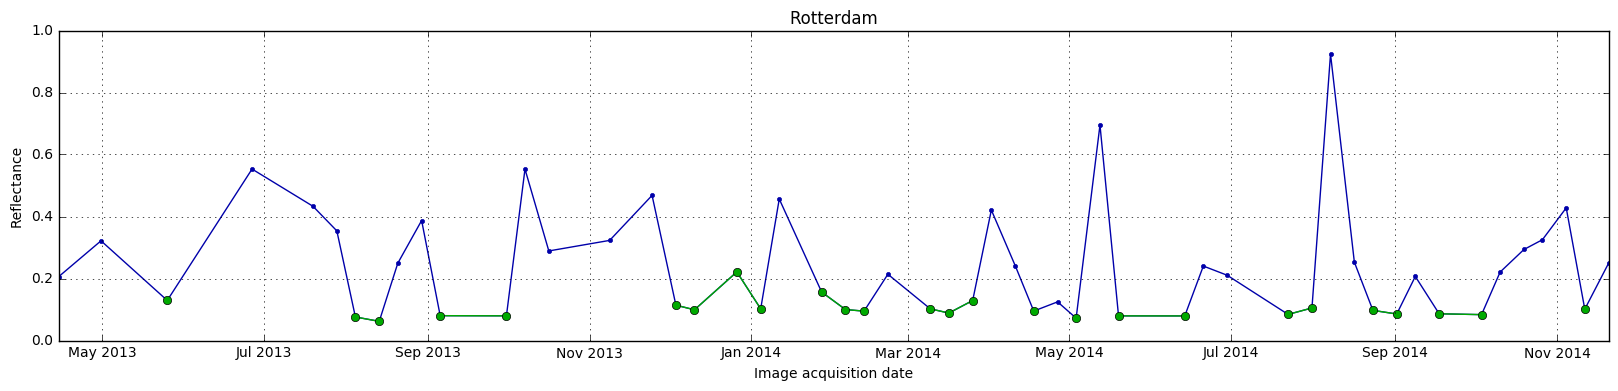

In [53]:
fig = plt.figure(figsize=(20, 4))

# plot the band values
ax = plt.subplot(111)
ax.set_title(location_name)
ax.plot(time, yData[:,2], 'b.-', color="#0000AA", label="deep_blue")
ax.plot(time, yData2[:,2], 'bo-', color="#00AA00", label="deep_blue")
ax.set_ylabel('Reflectance')
ax.set_xlabel('Image acquisition date')
ax.set_ylim([0, 1])

ax.grid(True)
fig.show()

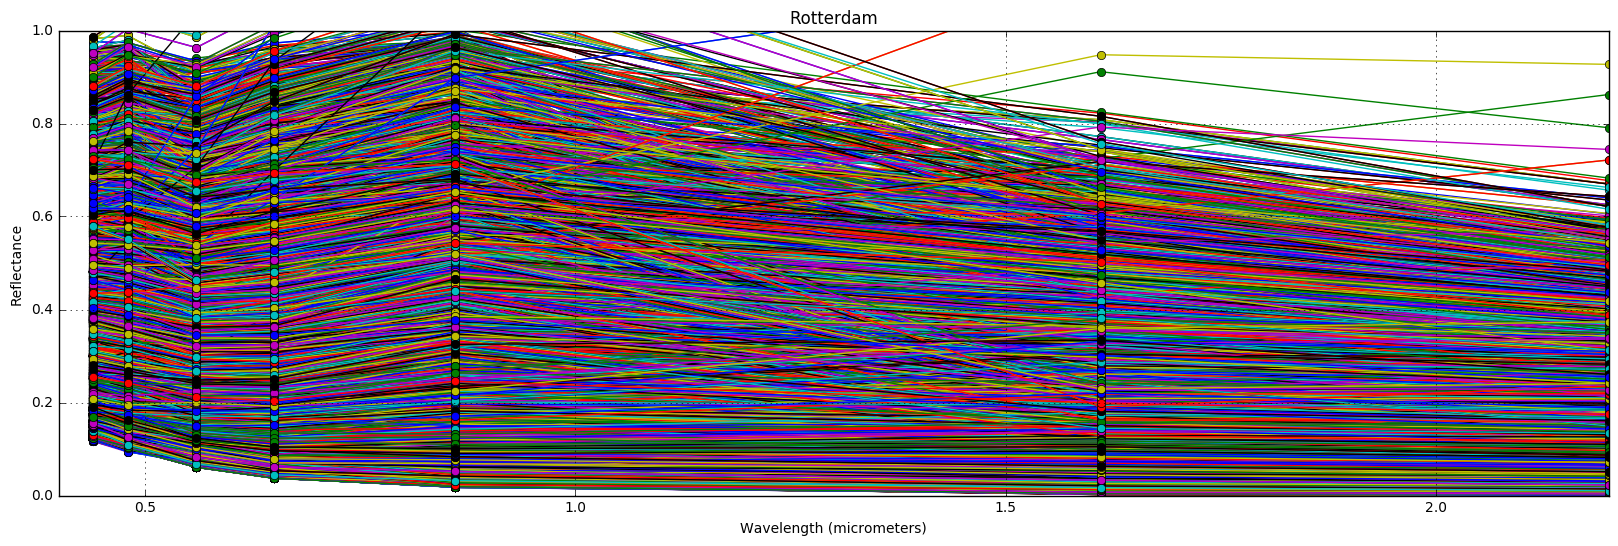

In [66]:
fig = plt.figure(figsize=(20, 6), dpi=80)
ax = plt.subplot(111)
yDataT = np.transpose(yData)
for (i, t) in enumerate(time):
    ax.plot(wavelengths, yDataT[:,i], 'o-', label=time[i])
    
ax.set_title(location_name)
ax.set_ylabel('Reflectance')
ax.set_xlabel('Wavelength (micrometers)')

# gee.set_legend_to_right(ax)
ax.grid(True)
ax.set_ylim([0, 1])

from matplotlib.path import Path
import matplotlib.patches as patches

# TODO: draw filled (RGB) rectangle to show visible spectrum + band numbers

In [19]:
# naive cloud filtering, skip images where RED > 0.2 or NIR > 0.09
def is_water(data):
    return not (data[3,i] > 0.19 or data[5,i] > 0.09)

26


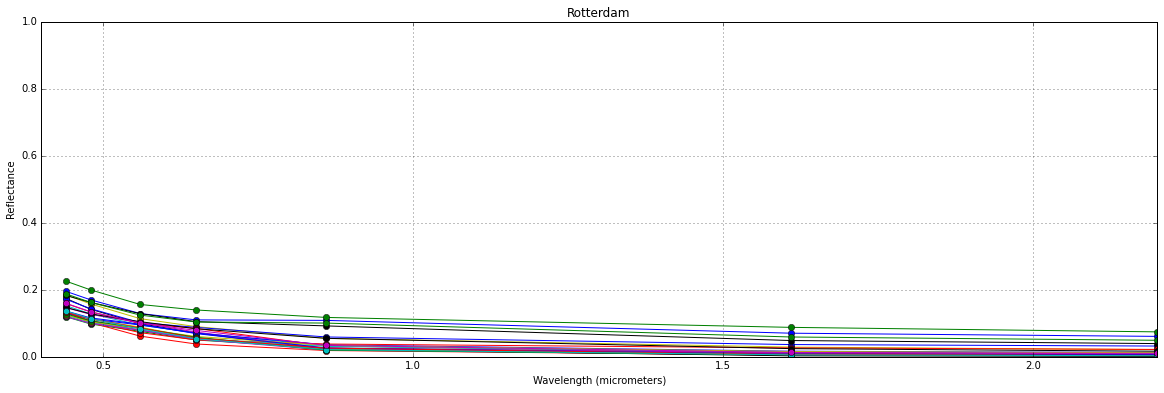

In [20]:
fig = plt.figure(figsize=(20, 6), dpi=80)
ax = plt.subplot(111)
yDataT = np.transpose(yData)

count = 0
for (i, t) in enumerate(time):
    if not is_water(yDataT):
        continue

    count += 1
    ax.plot(wavelengths, yDataT[:,i], 'o-', label=time[i])
    
print count 

ax.set_title(location_name)
ax.set_ylabel('Reflectance')
ax.set_xlabel('Wavelength (micrometers)')

# gee.set_legend_to_right(ax)
ax.grid(True)
ax.set_ylim([0, 1])

from matplotlib.path import Path
import matplotlib.patches as patches

# TODO: draw filled (RGB) rectangle to show visible spectrum + band numbers

In [ ]:
from IPython.display import display
map = GoogleMapsWidget(lat=y, lng=x, zoom=13)
display(map)

j = 0
for (i, n) in enumerate([f[0] for f in info[0:][1:]]):
    # if not is_water(yDataT):
    #    continue
    
    if np.isnan(yData[:,0][i]):
       continue
    
    if yData2[:,2][i] > 0.23:
        continue
    
    if j > 5:
        break
    
    visible = j == 0

    img = ee.Image(n)
    img = img.select(LC8_BANDS, bands)
    map.addLayer(image=img, vis_params={'bands':'swir1,nir,green'}, name=time[i], visible=visible)
    map.addLayer(image=remove_clouds(img), vis_params={'bands':'swir1,nir,green'}, name=str(time[i]) + '*', visible=visible)
    
    # map.addLayer(image=ee.Image(n), vis_params={'bands':'B6,B5,B3'}, name=time[i], visible=visible)
    
    j += 1
        
map.addLayer(ee.Feature(ee.Geometry.Point(x, y), {'label': 'center'}), vis_params={'color' : 'ff0000'}, name='POI')
map.addLayer(ee.Feature(polygon), vis_params={'color' : 'ff0000'}, name='POI (polygon)')

Javascript("""""", lib=[r'gee/FixHeight.js'])

In [22]:
print(map.lat, map.lng)
#map.addLayer(ee.Feature(ee.Geometry.Point(map.lng, map.lat), {'label': 'center'}), vis_params={'color' : '00ff00'}, name='center')

(51.898635, 4.35359)


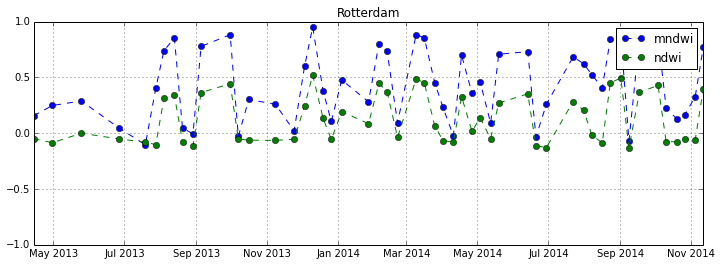

In [30]:
# calculate MNDWI
band3 = yData[:, 2] # green
band6 = yData[:, 5] # swir2

mndwi = (band3 - band6) / (band3 + band6)

# calculate NDWI
band4 = yData[:, 3] # red
band5 = yData[:, 4] # nir

ndwi = (band4 - band5) / (band4 + band5)

fig = figure(figsize=(12,4), dpi=80)
ax = plt.subplot(111)
ax.set_title(location_name)
ax.plot(time, mndwi, 'bo--', label='mndwi')
ax.plot(time, ndwi, 'go--', label='ndwi')
ax.set_ylim([-1, 1])
ax.grid()
ax.legend()

Fit MNDWI using OLS.

$$
\begin{bmatrix}
t_1 & 1 \\\
t_2 & 1 \\\
\vdots & \vdots \\\
t_n & 1
\end{bmatrix}
\begin{bmatrix}
x_0 \\\
x_1 
\end{bmatrix}=
\begin{bmatrix}
y_1 \\\
y_2 \\\
\vdots \\\
y_n
\end{bmatrix}
$$

$$ \mathbf{A}\mathbf{x} = \mathbf{b} $$

$$ \mathbf{x} = \mathbf{A} \backslash \mathbf{b} $$

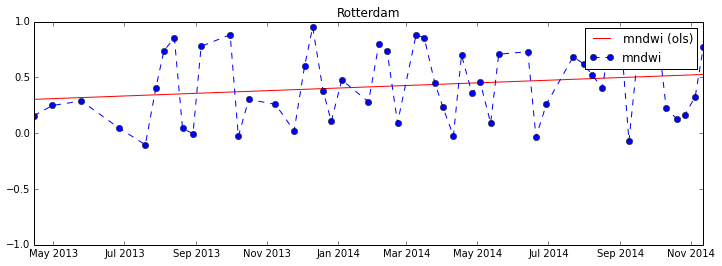

In [31]:
# Convert the timestamp to a numpy array
t = np.array([i.toordinal() for i in time])

A = array([ t, ones(len(t))]).transpose()
b = mndwi
x = linalg.lstsq(A,b)[0] # obtaining the parameters
b_hat = A.dot(x)

fig = figure(figsize=(12,4), dpi=80)
ax = plt.subplot(111)
ax.set_title(location_name)
ax.plot(time, b_hat.transpose(),'r-', label='mndwi (ols)')
ax.plot(time, mndwi, 'bo--', label='mndwi')
ax.grid()
ax.legend()
ax.set_ylim([-1, 1])
ax.grid()


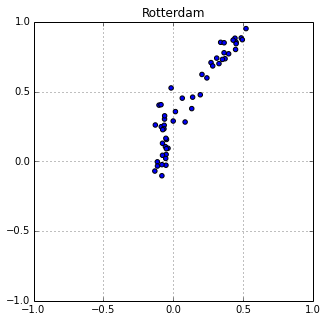

In [32]:
fig = figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_title(location_name)
ax.scatter(ndwi, mndwi)
ax.axis([-1.0, 1.0, -1.0, 1.0])
ax.grid()
ax.set_autoscale_on(False)


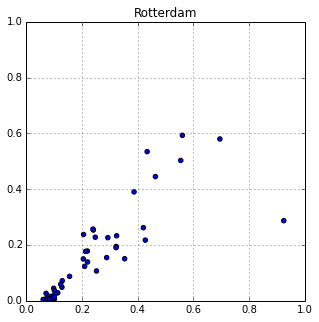

In [33]:
fig = figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_title(location_name)
ax.scatter(band3, band6)
ax.axis([0, 1, 0, 1])
ax.grid()
ax.set_autoscale_on(False)
